<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basics-of-camera" data-toc-modified-id="Basics-of-camera-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basics of camera</a></span><ul class="toc-item"><li><span><a href="#Camera-coordinates" data-toc-modified-id="Camera-coordinates-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Camera coordinates</a></span></li><li><span><a href="#Projection-Matrices" data-toc-modified-id="Projection-Matrices-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Projection Matrices</a></span></li></ul></li><li><span><a href="#Loading-the-dataset" data-toc-modified-id="Loading-the-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading the dataset</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Visualizing-the-pointcloud" data-toc-modified-id="Visualizing-the-pointcloud-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Visualizing the pointcloud</a></span></li></ul></li></ul></li></ul></div>

In [13]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Basics of camera

## Camera coordinates

Right hand rule system
- x direction goes to the right (u for image shown in gray)
- y direction goes down (v for image)
- z direction goes outside from the camera

In this image the ($X_{c}$, $Y_{c}$ and $Z_{c}$) is the coordinate for a point in the environment (world coordinate system) which is observed by the camera coordinate system. This point is captured in the image (shown in gray) by the camera as a point (x,y).

<img src="images/image_coordinate.png" width=800 height=800 />

In [21]:
poses = pd.read_csv('dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
print(first_pose)

Shape of position dataframe: (4541, 12)
First position:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. -0.]]


<IPython.core.display.Javascript object>


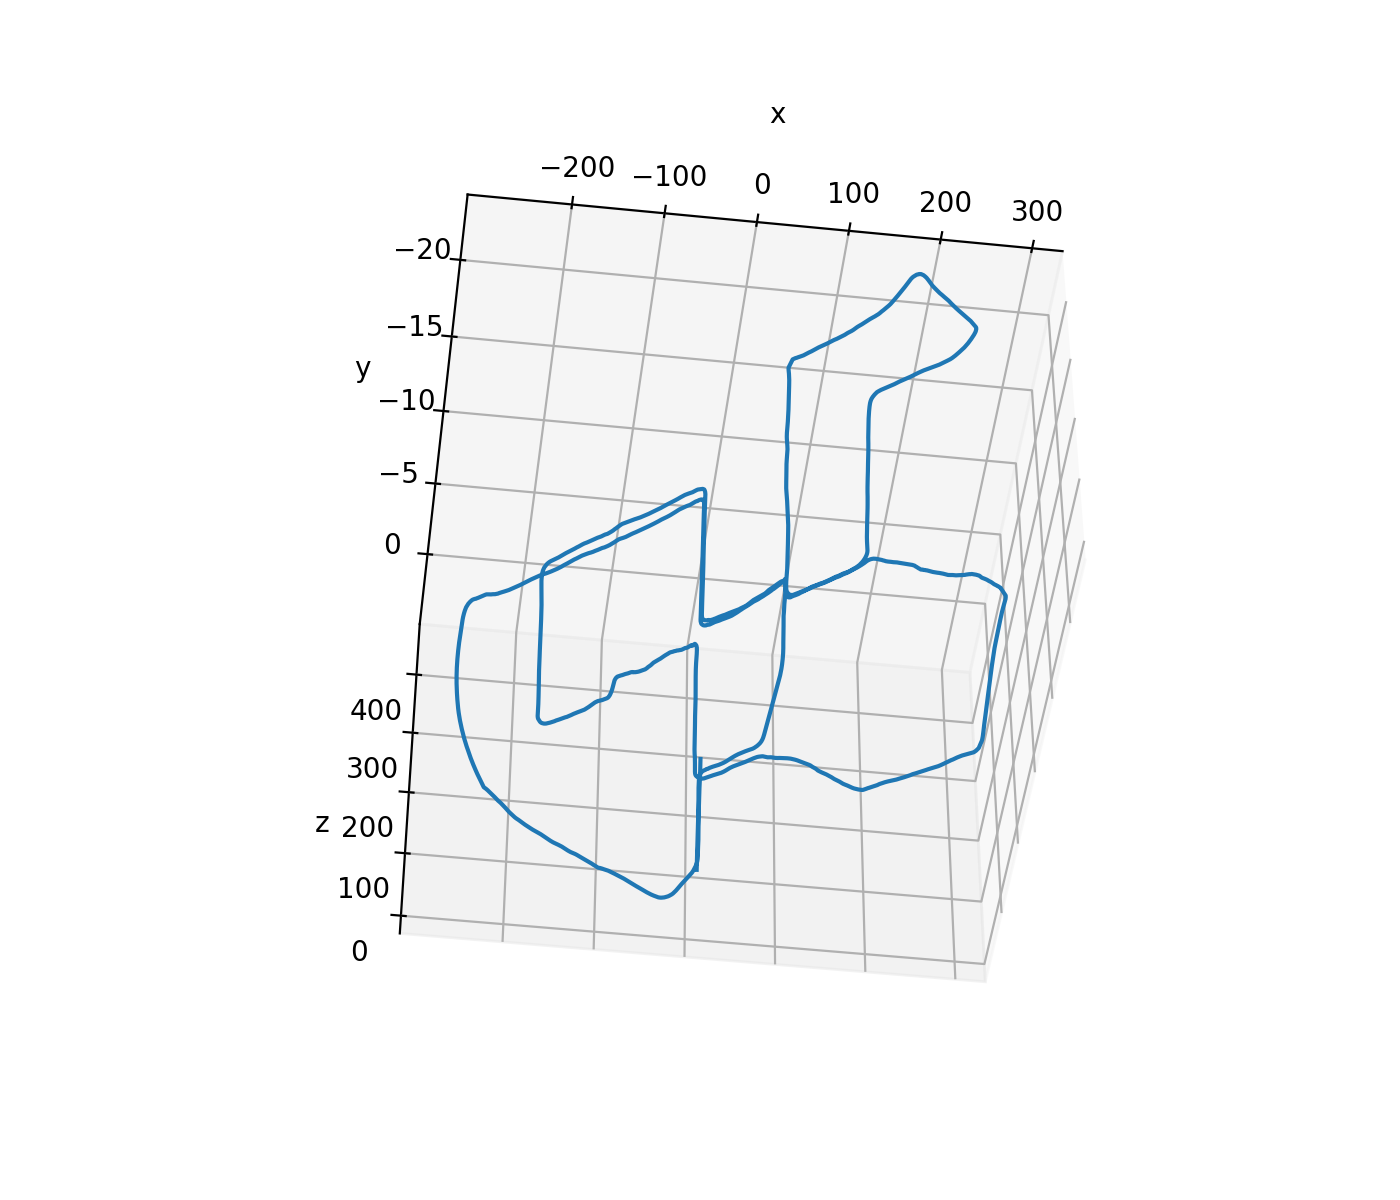

In [22]:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
    
%matplotlib notebook
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

## Projection Matrices

These matrices contain intrinsic information about the camera's focal length and optical center. Further, they also contain tranformation information which relates each camera's coordinate frame to the global coordinate frame. A projection matrix (3*4) takes 3D coordinates in the global coordinate frame and projects them onto the image plane of the camera through the formula present below.

<img src="images/projection_matrices1.png" width=800 height=800 />

NOTE: here $\tau$ is basically the depth of the object from the camera, so we lose the depth information and project everything in the 2d plane.

<img src="images/projection_matrices2.png" width=800 height=800 />

NOTE: intrinsic matrix $$ K = \begin{bmatrix} f_{x} & 0 & c_{x} \\ 0 & f_{y} & c_{y} \\ 0 & 0 & 1 \end{bmatrix}$$ where f are the focal point and c is the optical center of the image.

<img src="images/projection_matrices3.png" width=800 height=800 />

In [29]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [31]:
# Decomposing a projection matrix with OpenCV
# P = Intrinsic (R|T)
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


# Loading the dataset

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

NOTE: use generator to process a sequence of images

In [4]:
file_path = "dataset/sequences/00/image_0/"
left_images = os.listdir(file_path)
print(" the number of images in this sequence is:", len(left_images))

 the number of images in this sequence is: 4541


(376, 1241)

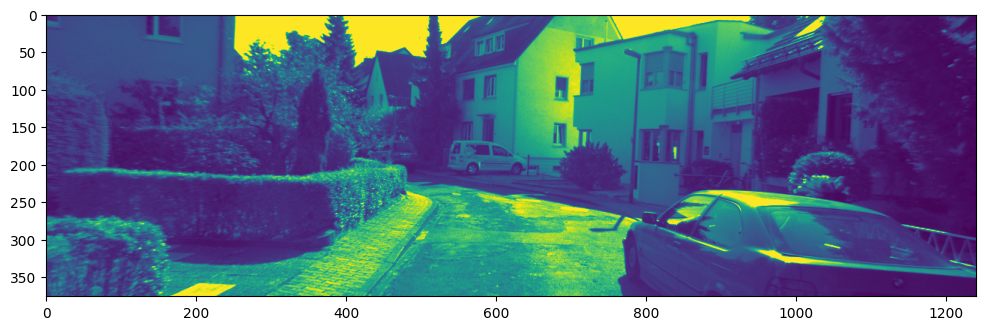

In [7]:
plt.figure(figsize=(12,10))
first_image = cv2.imread(file_path + left_images[0], 0)
plt.imshow(first_image)
first_image.shape

In [22]:
file_path = "dataset/sequences/00/"
velodyne_file_path = os.listdir(file_path + "velodyne")
pointclouds = np.fromfile(file_path + "velodyne/" + velodyne_file_path[0], dtype=np.float32)
# reshaping it to x,y,z and one more value
pointclouds = pointclouds.reshape(-1,4)
pointclouds.shape

(112328, 4)

### Visualizing the pointcloud

<IPython.core.display.Javascript object>


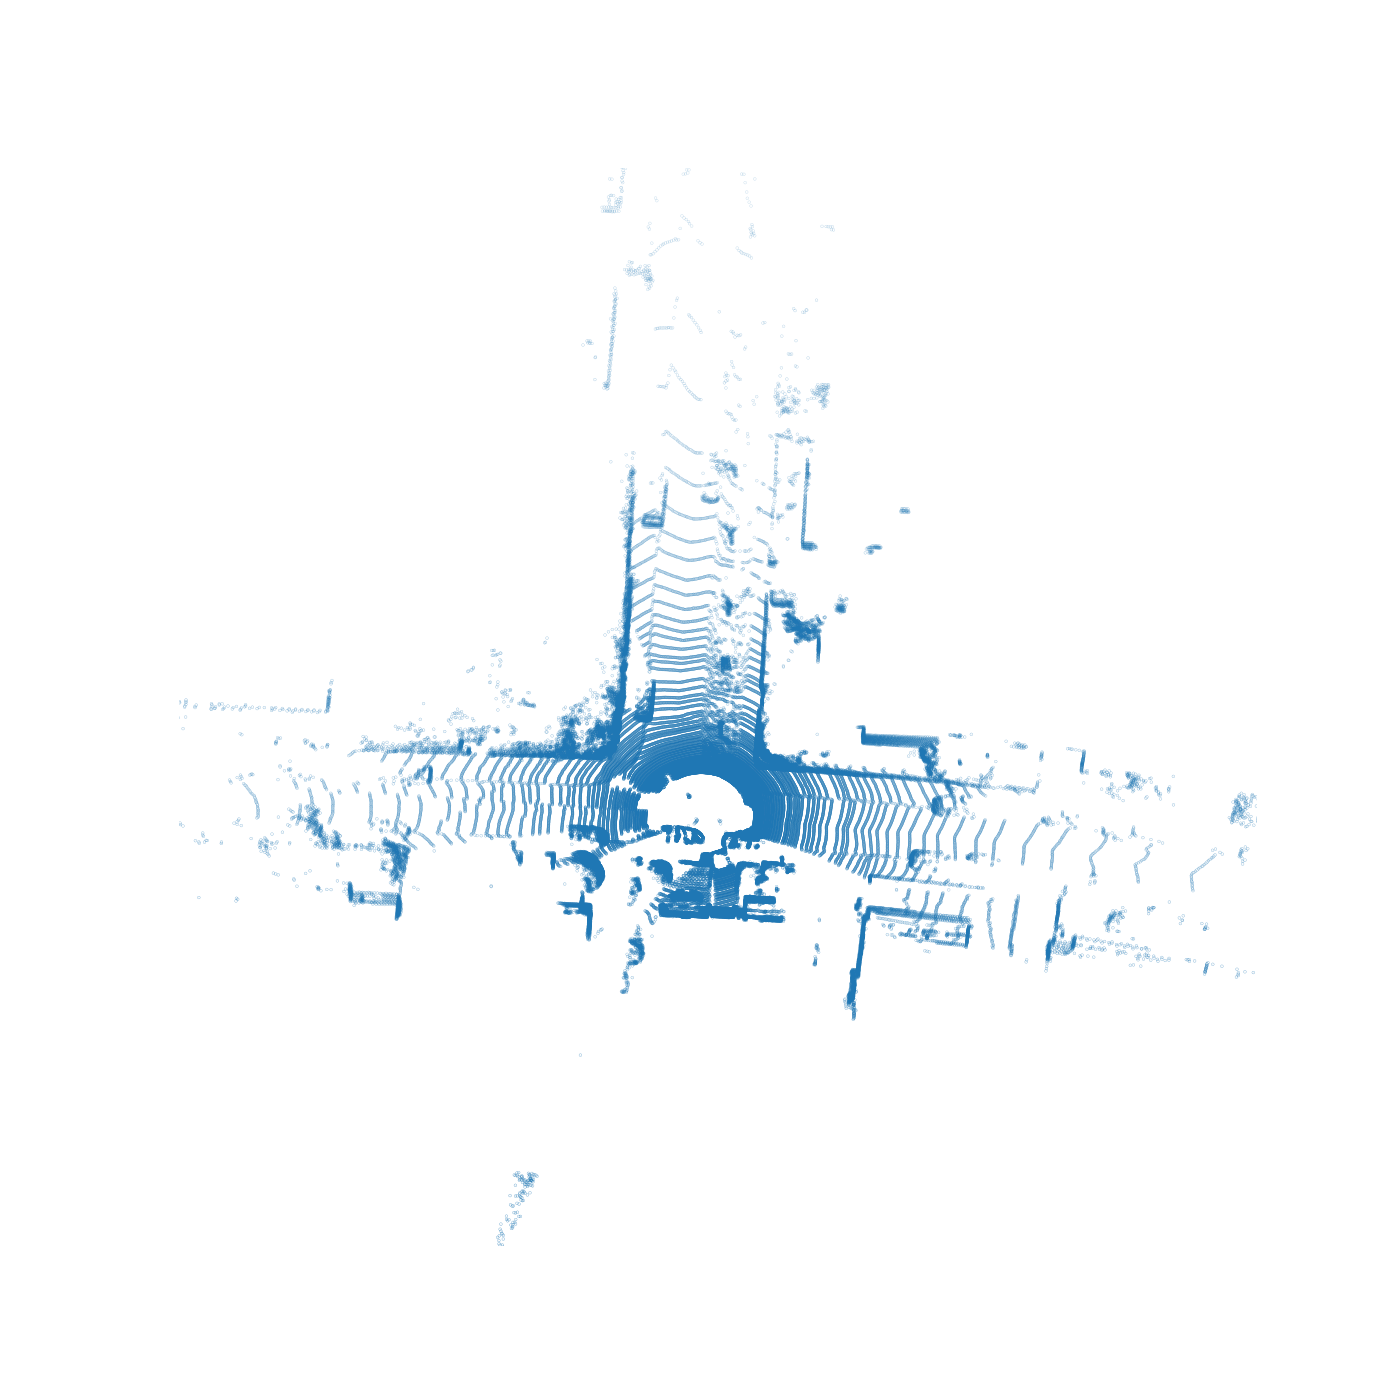

In [41]:
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111,projection="3d")
x = pointclouds[:,0]
y = pointclouds[:,1]
z = pointclouds[:,2]
ax.set_box_aspect((np.ptp(x),np.ptp(y),np.ptp(z)))
ax.scatter(x,y,z,s=0.01)
ax.grid(False)
ax.axis("off")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=40, azim=100)